#### PGE 382 - Numerical Methods in Petroleum and Geosystems Engineering
#### Renato Poli - rep2656

#### CP7 - Apr, 3rd

In [3]:
from math import pi, sin, cos, exp
import numpy as np
from numpy import linspace, zeros, arange
from numpy import ix_ as ix
np.set_printoptions(threshold=10000, linewidth=10000)
from numpy import exp, linspace, vectorize
import matplotlib.pyplot as plt
plt.style.use('paper.mplstyle')

dx = 0.125 ; dy = dx ; dz = dx
Tf = 0.25 ; Nt=10
mu = 0.5

X = np.arange(0,1+dx,dx) ; Ni = len(X)
Y = np.arange(0,1+dy,dy) ; Nj = len(Y)
Z = np.arange(0,1+dz,dz) ; Nk = len(Z)

Nijk = Ni * Nj * Nk

dt = Tf/Nt ; Nt = Nt + 1

# Global index
def _(i,j,k) : return i + Ni*j+ Ni*Nj*k
def exact( t,x,y,z) :
    return 1/( 1+exp(x/2/mu + y/2/mu + z/2/mu - 3*t/4/mu) ) 

def build_exact() :
    global Uexact, Nt, Ni, Nj, Nk
    Uexact = zeros( [Nt,Ni,Nj,Nk] )
    for n in arange(0,Nt) :
        for i in arange(Ni) :
            for j in arange(Nj) :
                for k in arange(Nk) :
                    Uexact[n,i,j,k] = exact(n*dt,i*dx,j*dy,k*dz)

# The list of free dofs
def build_Df() :
    global Df, Dp, Nt, Ni, Nj, Nk

    Df=[]
    for i in arange(1,Ni-1) :
        for j in arange(1,Nj-1) :
            for k in arange(1,Nk-1) :
                Df.append( _(i,j,k) )
    Dp=[]
    for i in arange(0,Ni) :
        for j in arange(0,Nj) :
            Dp.append( _(0,i,j) )
            Dp.append( _(Ni-1,i,j) )

            Dp.append( _(i,0,j) )
            Dp.append( _(i,Nj-1,j) )

            Dp.append( _(i,j,0) )
            Dp.append( _(i,j,Nk-1) )

# Assign BCs to solution vector U
def init_bcs() :
    global U, Uexact
    U = zeros( [Nt,Ni,Nj,Nk] )
    U[0,:,:,:] = Uexact[0,:,:,:] #IC
    U[:,0,:,:] = Uexact[:,0,:,:] #I=0
    U[:,:,0,:] = Uexact[:,:,0,:] #J=0
    U[:,:,:,0] = Uexact[:,:,:,0] #K=0
    U[:,Ni-1,:,:] = Uexact[:,Ni-1,:,:]
    U[:,:,Nj-1,:] = Uexact[:,:,Nj-1,:]
    U[:,:,:,Nk-1] = Uexact[:,:,:,Nk-1]

# Global solution vector
build_exact()
init_bcs()
build_Df()

Dff_ix = ix( Df, Df )
Df_ix = ix( Df )
Dp_ix = ix(Dp)
for n in arange(1,Nt) :
    print(f"Solving timestep {n} ...")

    # Solution from the previous TS
    Un = U[n-1,:,:,:].flatten()
    # Apply new BCs in Uk
    Uk = Un.copy()
    Uk[Dp_ix] = Uexact[n,:,:,:].flatten()[Dp_ix]

    nk = 0 #newton loop index
    while(1) :      
        # Jacobians and functions
        J = zeros([ Nijk, Nijk ] )
        F = zeros( Nijk )

        for i in arange(1,Ni-1) :
            for j in arange(1,Nj-1) :
                for k in arange(1,Nk-1) :
                    _ijk = _(i,j,k)
                    _0jk = _(i-1,j,k)
                    _1jk = _(i+1,j,k)
                    _i0k = _(i,j-1,k)
                    _i1k = _(i,j+1,k)
                    _ij0 = _(i,j,k-1)
                    _ij1 = _(i,j,k+1)

                    J[_ijk,_ijk] += -2*Uk[_ijk]*(1/dx + 1/dy + 1/dz) +\
                                     Uk[_0jk]/dx + Uk[_i0k]/dy + Uk[_ij0]/dz +\
                                     (-2*mu)*(1/dx/dx + 1/dy/dy + 1/dz/dz) +\
                                     (-1/dt)

                    J[_ijk,_0jk] += Uk[_ijk]/dx + mu/dx/dx
                    J[_ijk,_1jk] += mu/dx/dx
                    J[_ijk,_i0k] += Uk[_ijk]/dy + mu/dy/dy
                    J[_ijk,_i1k] += mu/dy/dy
                    J[_ijk,_ij0] += Uk[_ijk]/dz + mu/dz/dz
                    J[_ijk,_ij1] += mu/dz/dz
      
                    F[_ijk] += (-Uk[_ijk])*(Uk[_ijk]-Uk[_0jk])/dx
                    F[_ijk] += (-Uk[_ijk])*(Uk[_ijk]-Uk[_i0k])/dy
                    F[_ijk] += (-Uk[_ijk])*(Uk[_ijk]-Uk[_ij0])/dz
                    F[_ijk] += mu*(Uk[_0jk] - 2*Uk[_ijk] + Uk[_1jk])/dx/dx
                    F[_ijk] += mu*(Uk[_i0k] - 2*Uk[_ijk] + Uk[_i1k])/dy/dy
                    F[_ijk] += mu*(Uk[_ij0] - 2*Uk[_ijk] + Uk[_ij1])/dz/dz
                    F[_ijk] += ( Un[_ijk] - Uk[_ijk] )/dt
                    
        # Solve for the unknowns, update vectors
        Kf = J[Dff_ix] ; Ff = F[Df_ix]   
        delta = np.linalg.solve( Kf, -Ff )
        # Collect solution 
        Uk[Df_ix] += delta
        err = np.linalg.norm(delta)

        # Check for convergence
        nk += 1
        print(f"   Newton iteration #{nk} ... (err={err:.3e})")
        if err < 1e-15 : break
        if nk > 50 : break
    
    U[n,:,:,:] = Uk.reshape(Ni,Nj,Nk)
    # Compare with exact
    DIFF = U[n,:,:,:] - Uexact[n,:,:,:]
    print(f"Difference from exact: {np.linalg.norm(DIFF)}")

Solving timestep 1 ...
   Newton iteration #1 ... (err=1.105e-01)
   Newton iteration #2 ... (err=5.436e-05)
   Newton iteration #3 ... (err=3.936e-11)
   Newton iteration #4 ... (err=1.731e-16)
Difference from exact: 0.0017434691489342754
Solving timestep 2 ...
   Newton iteration #1 ... (err=1.122e-01)
   Newton iteration #2 ... (err=5.558e-05)
   Newton iteration #3 ... (err=4.055e-11)
   Newton iteration #4 ... (err=1.951e-16)
Difference from exact: 0.002993242288226833
Solving timestep 3 ...
   Newton iteration #1 ... (err=1.141e-01)
   Newton iteration #2 ... (err=5.703e-05)
   Newton iteration #3 ... (err=4.204e-11)
   Newton iteration #4 ... (err=1.835e-16)
Difference from exact: 0.003914008727057912
Solving timestep 4 ...
   Newton iteration #1 ... (err=1.161e-01)
   Newton iteration #2 ... (err=5.857e-05)
   Newton iteration #3 ... (err=4.366e-11)
   Newton iteration #4 ... (err=2.137e-16)
Difference from exact: 0.00460208331625954
Solving timestep 5 ...
   Newton iteration #

C:\Users\rebpo\AppData\Local\Temp\ipykernel_16848\1638510875.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


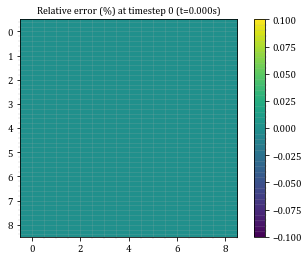

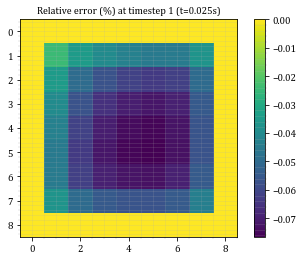

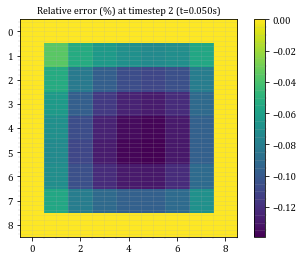

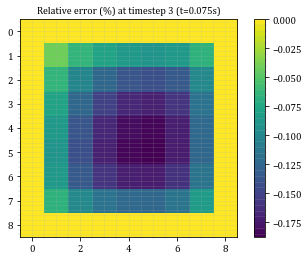

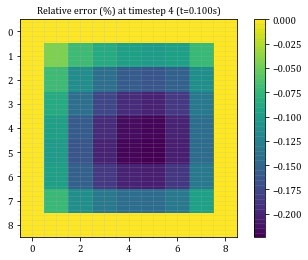

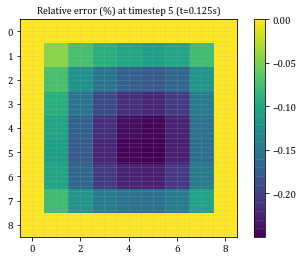

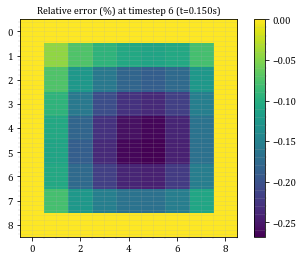

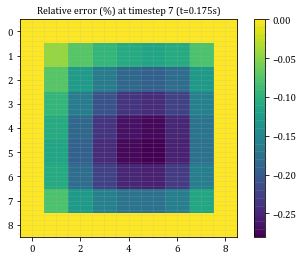

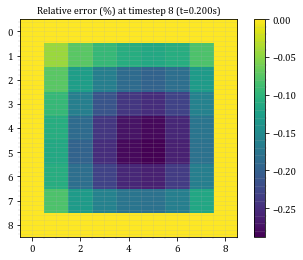

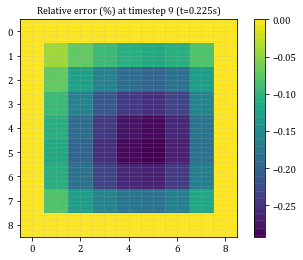

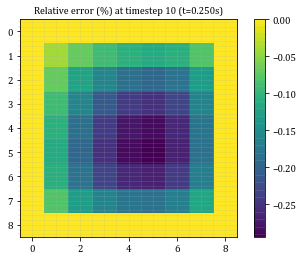

In [4]:
k=5
for n in arange(Nt) :
    plt.figure()    
    err = ( 1 - U[n,:,:,k] / Uexact[n,:,:,k] ) * 100
    plt.imshow( err )
    plt.colorbar()
    plt.title(f"Relative error (%) at timestep {n} (t={n*dt:.3f}s)")